# Forecasting Hierarchical Models - Part III

In this third notebook, we extend the hierarchical forecasting model from [Part II](https://juanitorduz.github.io/numpyro_hierarchical_forecasting_2/) by adding a **neural network component** to the state transition function. This creates a **Hybrid Deep State-Space Model** that combines probabilistic modeling with deep learning.

**Why?** This is a personal experiment to explore how to integrate neural networks with hierarchical models. It is not adding complexity for the sake of complexity. It is rather an exploratory exercise to see if this approach can lead to better forecasting performance.

**How?** We use the [`NNX`](https://flax.readthedocs.io/en/v0.8.3/experimental/nnx/index.html) integration with NumPyro via the [`nnx_module`](https://num.pyro.ai/en/stable/primitives.html#nnx-module) API.

## Prepare Notebook


In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.contrib.module import nnx_module
from numpyro.examples.datasets import load_bart_od
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.reparam import LocScaleReparam

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=14)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
# %load_ext jaxtyping
# %jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


## Read Data

We load the BART dataset as in the previous examples.

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
(78888, 50, 50)
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In this example, we model all the rides from all stations to all other stations.


In [3]:
data = jnp.log1p(np.permute_dims(dataset["counts"], (1, 2, 0)))
T = data.shape[-2]
print(data.shape)

(50, 50, 78888)


## Train - Test Split

Similarly as in the previous examples, for training purposes we will use data from 90 days before the test data.


In [4]:
T2 = data.shape[-1]  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [5]:
y = data[..., T0:T2]
y_train = data[..., T0:T1]
y_test = data[..., T1:T2]

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (50, 50, 2496)
y_train: (50, 50, 2160)
y_test: (50, 50, 336)


We do a simple train-test split.

In [6]:
n_stations = y_train.shape[0]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

assert time_train.size + time_test.size == time.size
assert y_train.shape == (n_stations, n_stations, t_max_train)
assert y_test.shape == (n_stations, n_stations, t_max_test)
assert covariates.shape == y.shape
assert covariates_train.shape == y_train.shape
assert covariates_test.shape == y_test.shape

## Repeating Seasonal Features

We also need the JAX version of the [`periodic_repeat`](https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat) function.


In [7]:
def periodic_repeat_jax(tensor: Array, size: int, dim: int) -> Array:
    assert isinstance(size, int) and size >= 0
    assert isinstance(dim, int)
    if dim >= 0:
        dim -= tensor.ndim

    period = tensor.shape[dim]
    repeats = [1] * tensor.ndim
    repeats[dim] = (size + period - 1) // period
    result = jnp.tile(tensor, repeats)

    slices = [slice(None)] * tensor.ndim
    slices[dim] = slice(None, size)

    return result[tuple(slices)]

## Neural Network Definition (NEW in Part III)

We  now define two Flax NNX modules:

- **`StationEmbedding`**

Maps each station index to a learnable dense vector. This allows the NN to learn station-specific dynamics.

- **`TransitionNetwork`**

A simple MLP that takes as input:

- **Normalized previous level**: `tanh(level / 10)` to keep inputs bounded
- **Hour of day**: Cyclical encoding `(sin, cos)` of hour (0-23)
- **Day of week**: Cyclical encoding `(sin, cos)` of day (0-6)
- **Station embedding**: Learnable vector for each station

In [8]:
class StationEmbedding(nnx.Module):
    """Learnable embeddings for stations."""

    def __init__(self, n_stations: int, embed_dim: int, rngs: nnx.Rngs):
        self.embedding = nnx.Embed(
            num_embeddings=n_stations, features=embed_dim, rngs=rngs
        )

    def __call__(self, station_idx: jax.Array) -> jax.Array:
        return self.embedding(station_idx)


class TransitionNetwork(nnx.Module):
    """Neural network for the transition function correction term."""

    def __init__(
        self,
        n_stations: int,
        embed_dim: int,
        hidden_dims: list[int],
        rngs: nnx.Rngs,
    ) -> None:
        self.embed_dim = embed_dim
        self.station_embed = StationEmbedding(n_stations, embed_dim, rngs)

        # Input: level(1) + hour_sin_cos(2) + dow_sin_cos(2) + embed
        input_dim = 1 + 2 + 2 + embed_dim

        # Build MLP layers
        self.layers = nnx.List([])
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nnx.Linear(prev_dim, hidden_dim, rngs=rngs))
            prev_dim = hidden_dim
        self.output_layer = nnx.Linear(prev_dim, 1, rngs=rngs)

    def __call__(
        self,
        normalized_level: jax.Array,
        hour_of_day: float,
        day_of_week: float,
        station_indices: jax.Array,
    ) -> jax.Array:
        n_stations = normalized_level.shape[0]

        # Station embeddings
        station_emb = self.station_embed(station_indices)

        # Cyclical time encoding
        hour_angle = 2 * jnp.pi * hour_of_day / 24.0
        hour_features = jnp.broadcast_to(
            jnp.stack([jnp.sin(hour_angle), jnp.cos(hour_angle)]), (n_stations, 2)
        )
        dow_angle = 2 * jnp.pi * day_of_week / 7.0
        dow_features = jnp.broadcast_to(
            jnp.stack([jnp.sin(dow_angle), jnp.cos(dow_angle)]), (n_stations, 2)
        )

        # Concatenate all features
        x = jnp.concatenate(
            [normalized_level[:, None], hour_features, dow_features, station_emb],
            axis=-1,
        )

        for layer in self.layers:
            x = jax.nn.relu(layer(x))

        return self.output_layer(x)

## Initialize Neural Network

Following the pattern from [online_game_ate](https://juanitorduz.github.io/online_game_ate/), we initialize the neural network **outside** the model function and pass it as an argument. Inside the model, we register it with `nnx_module` so NumPyro can optimize its parameters via SVI.


In [9]:
# Neural network hyperparameters
embed_dim = 24
hidden_dims = [4, 16, 16, 4]

# Initialize random number generators for Flax
rng_key, rng_subkey = random.split(rng_key)

# Initialize the transition network
transition_nn = TransitionNetwork(
    n_stations=n_stations,
    embed_dim=embed_dim,
    hidden_dims=hidden_dims,
    rngs=nnx.Rngs(rng_subkey),
)

## Model Specification

The model below is **identical to Part II** except for the highlighted addition:

### Local Level Transition (the key difference)

In the previous notebook, we had a simple drift term:   

**Part II:**
```python
current_level = previous_level + drift[t]
```

Now, we have a drift term and a neural network correction term:

**Part III (this notebook):**
```python
current_level = previous_level + drift[t] + nn_residual_scale * nn_output[t]
#                                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#                                           NEW: Neural network correction
```

Let's see how to implement this in the model in NumPyro.

In [10]:
def model(
    covariates: Float[Array, "n_series n_series t_max"],
    transition_nn: TransitionNetwork,
    y: Float[Array, "n_series n_series t_max"] | None = None,
) -> None:
    """Hybrid Deep State-Space Model: Part II structure + neural network correction."""
    n_series, _, t_max = covariates.shape
    # Station indices for NN embeddings
    station_indices = jnp.arange(n_series)

    # Register neural network with NumPyro
    transition_nn = nnx_module("transition", transition_nn)

    # Define the plates
    origin_plate = numpyro.plate("origin", n_series, dim=-3)
    destin_plate = numpyro.plate("destin", n_series, dim=-2)
    hour_of_week_plate = numpyro.plate("hour_of_week", 24 * 7, dim=-1)

    # --- Drift parameters ---
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-20, scale=5))
    destin_centered = numpyro.sample("destin_centered", dist.Uniform(low=0, high=1))

    with (
        destin_plate,
        numpyro.plate("time", t_max),
        numpyro.handlers.reparam(
            config={"drift": LocScaleReparam(centered=destin_centered)}
        ),
    ):
        drift = numpyro.sample("drift", dist.Normal(loc=0, scale=drift_scale))

    # --- Global NN residual scale ---
    nn_residual_scale = numpyro.sample(
        "nn_residual_scale", dist.LogNormal(loc=-2, scale=2)
    )

    # --- Seasonal parameters ---
    with origin_plate, hour_of_week_plate:
        origin_seasonal = numpyro.sample("origin_seasonal", dist.Normal(loc=0, scale=5))

    with destin_plate, hour_of_week_plate:
        destin_seasonal = numpyro.sample("destin_seasonal", dist.Normal(loc=0, scale=5))

    # --- Pairwise station affinity ---
    with origin_plate, destin_plate:
        pairwise = numpyro.sample("pairwise", dist.Normal(0, 1))

    # --- Observation scales ---
    with origin_plate:
        origin_scale = numpyro.sample("origin_scale", dist.LogNormal(-5, 5))
    with destin_plate:
        destin_scale = numpyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

    # Repeat seasonal to match time series length
    seasonal = origin_seasonal + destin_seasonal
    seasonal_repeat = periodic_repeat_jax(seasonal, t_max, dim=-1)

    # --- Local level transition function ---
    def transition_fn(
        carry: Float[Array, " n_series"], t: int
    ) -> tuple[Float[Array, " n_series"], Float[Array, " n_series"]]:
        # Drift term
        previous_level = carry
        current_drift = drift[..., t]

        # Neural network correction (NEW in Part III)
        normalized_level = jnp.tanh(previous_level / 10.0)
        hour_of_week = t % (24 * 7)
        hour_of_day = hour_of_week % 24
        day_of_week = hour_of_week // 24

        nn_output = transition_nn(
            normalized_level=normalized_level,
            hour_of_day=hour_of_day,
            day_of_week=day_of_week,
            station_indices=station_indices,
        ).reshape(n_series)

        # Combine: drift + NN correction
        current_level = previous_level + current_drift + nn_residual_scale * nn_output
        # Clip to prevent numerical overflow
        current_level = jnp.clip(current_level, -50.0, 50.0)

        return current_level, current_level

    # Compute latent levels using scan
    _, pred_levels = scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    # Reshape for broadcasting
    pred_levels = pred_levels.transpose(1, 0)[None, :, :]

    # Compute mean
    mu = pred_levels + seasonal_repeat + pairwise

    # Sample observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=scale))

We can visualize the model structure. Note the new `transition` node representing the neural network parameters.


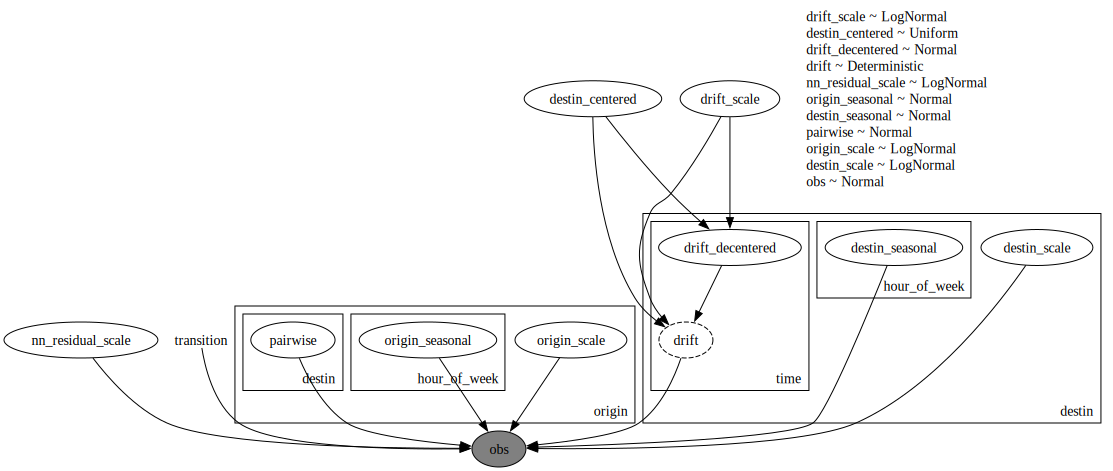

In [11]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "covariates": covariates_train,
        "transition_nn": transition_nn,
        "y": y_train,
    },
    render_distributions=True,
    render_params=True,
)

## Prior Predictive Checks

As in Part II, we perform prior predictive checks. Note that we pass `transition_nn` as an argument.


In [12]:
prior_predictive = Predictive(model=model, num_samples=500, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)

prior_samples = prior_predictive(
    rng_subkey,
    covariates_train,
    transition_nn,
)

idata_prior = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

Let's plot the prior predictive distribution for the first $8$ stations for the destination station `ANTC`.


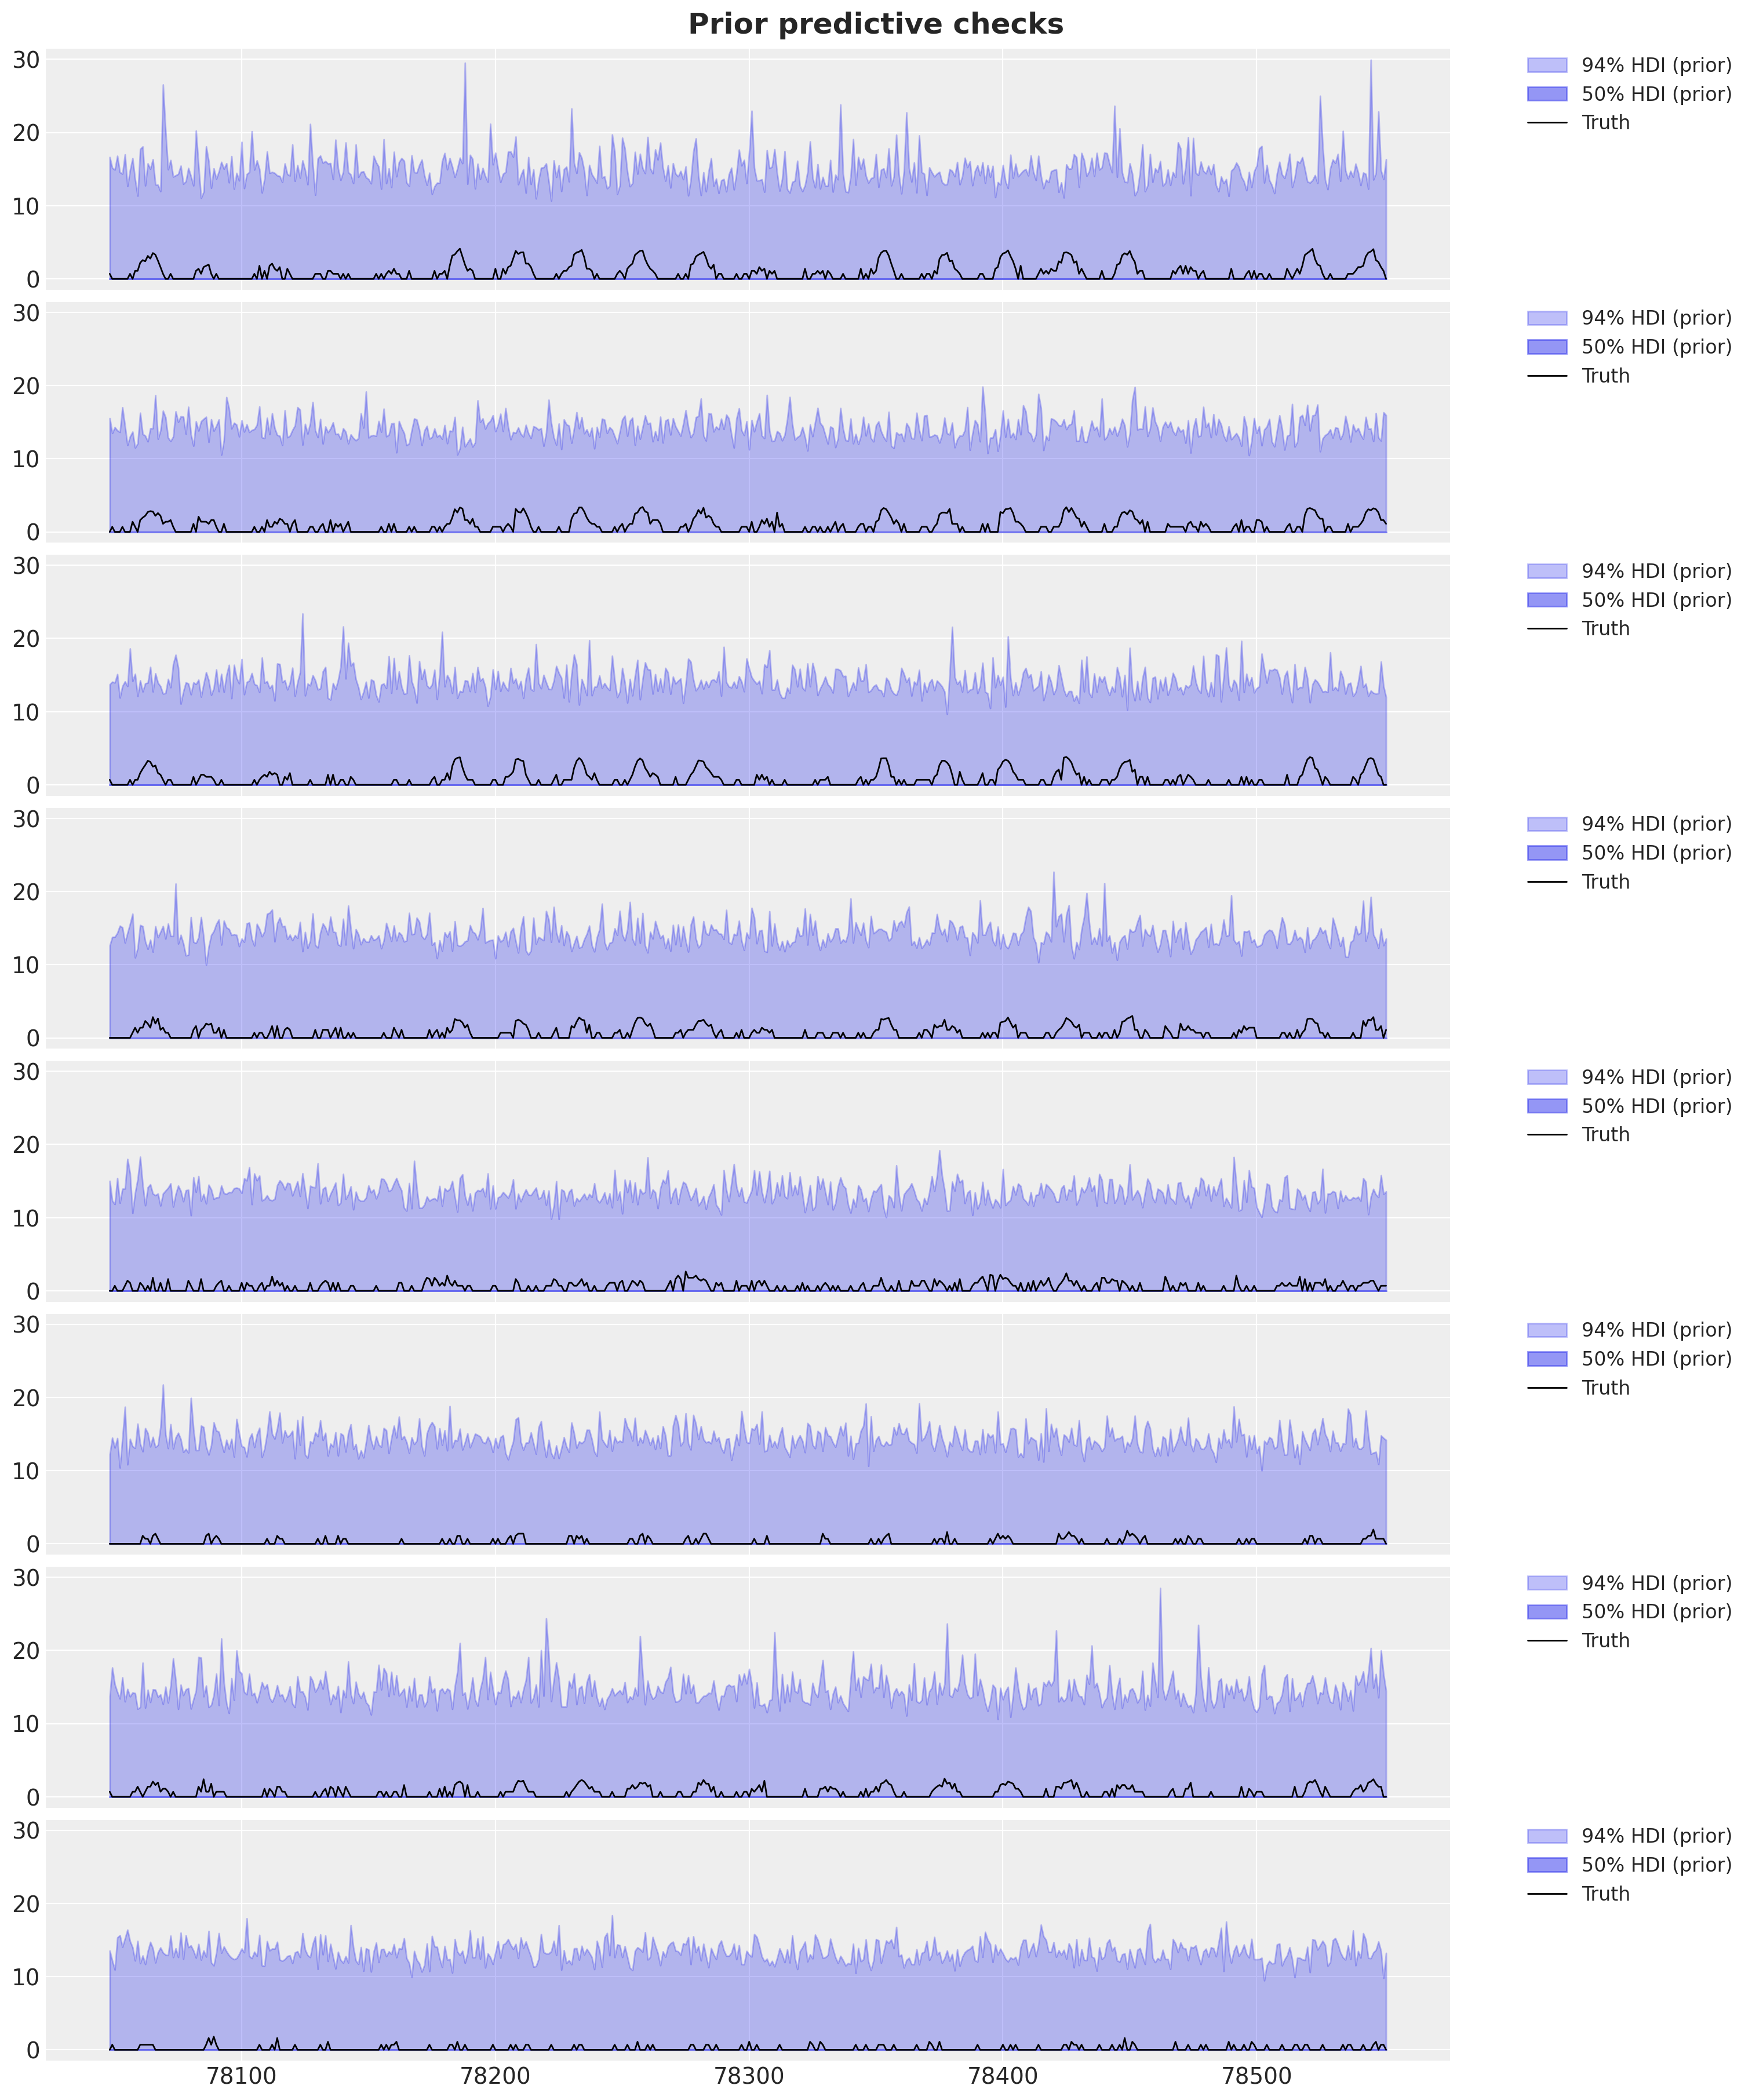

In [13]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 3 * (24 * 7)],
            idata_prior["prior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 3 * (24 * 7)]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (prior)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time_train[time_train >= T1 - 3 * (24 * 7)],
        data[i, idx, T1 - 3 * (24 * 7) : T1],
        "black",
        lw=1,
        label="Truth",
    )

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle("Prior predictive checks", fontsize=18, fontweight="bold");

Overall, the prior predictive distrubution seem very reasonable.

## Inference with SVI

We fit the model using SVI, the same approach as Part II. That being said, we use a better optimization routine: a scheduler that decays the learning rate over time (and this can influence the model convergence and performance!). For more detials on SVI in NumPyro, see ["Introduction to Stochastic Variational Inference with NumPyro"](https://juanitorduz.github.io/intro_svi/).


100%|██████████| 30000/30000 [34:19<00:00, 14.56it/s, init loss: 1446333056.0000, avg. loss [28501-30000]: 3582207.2500]


CPU times: user 1h 17min 14s, sys: 18min 20s, total: 1h 35min 35s
Wall time: 34min 28s


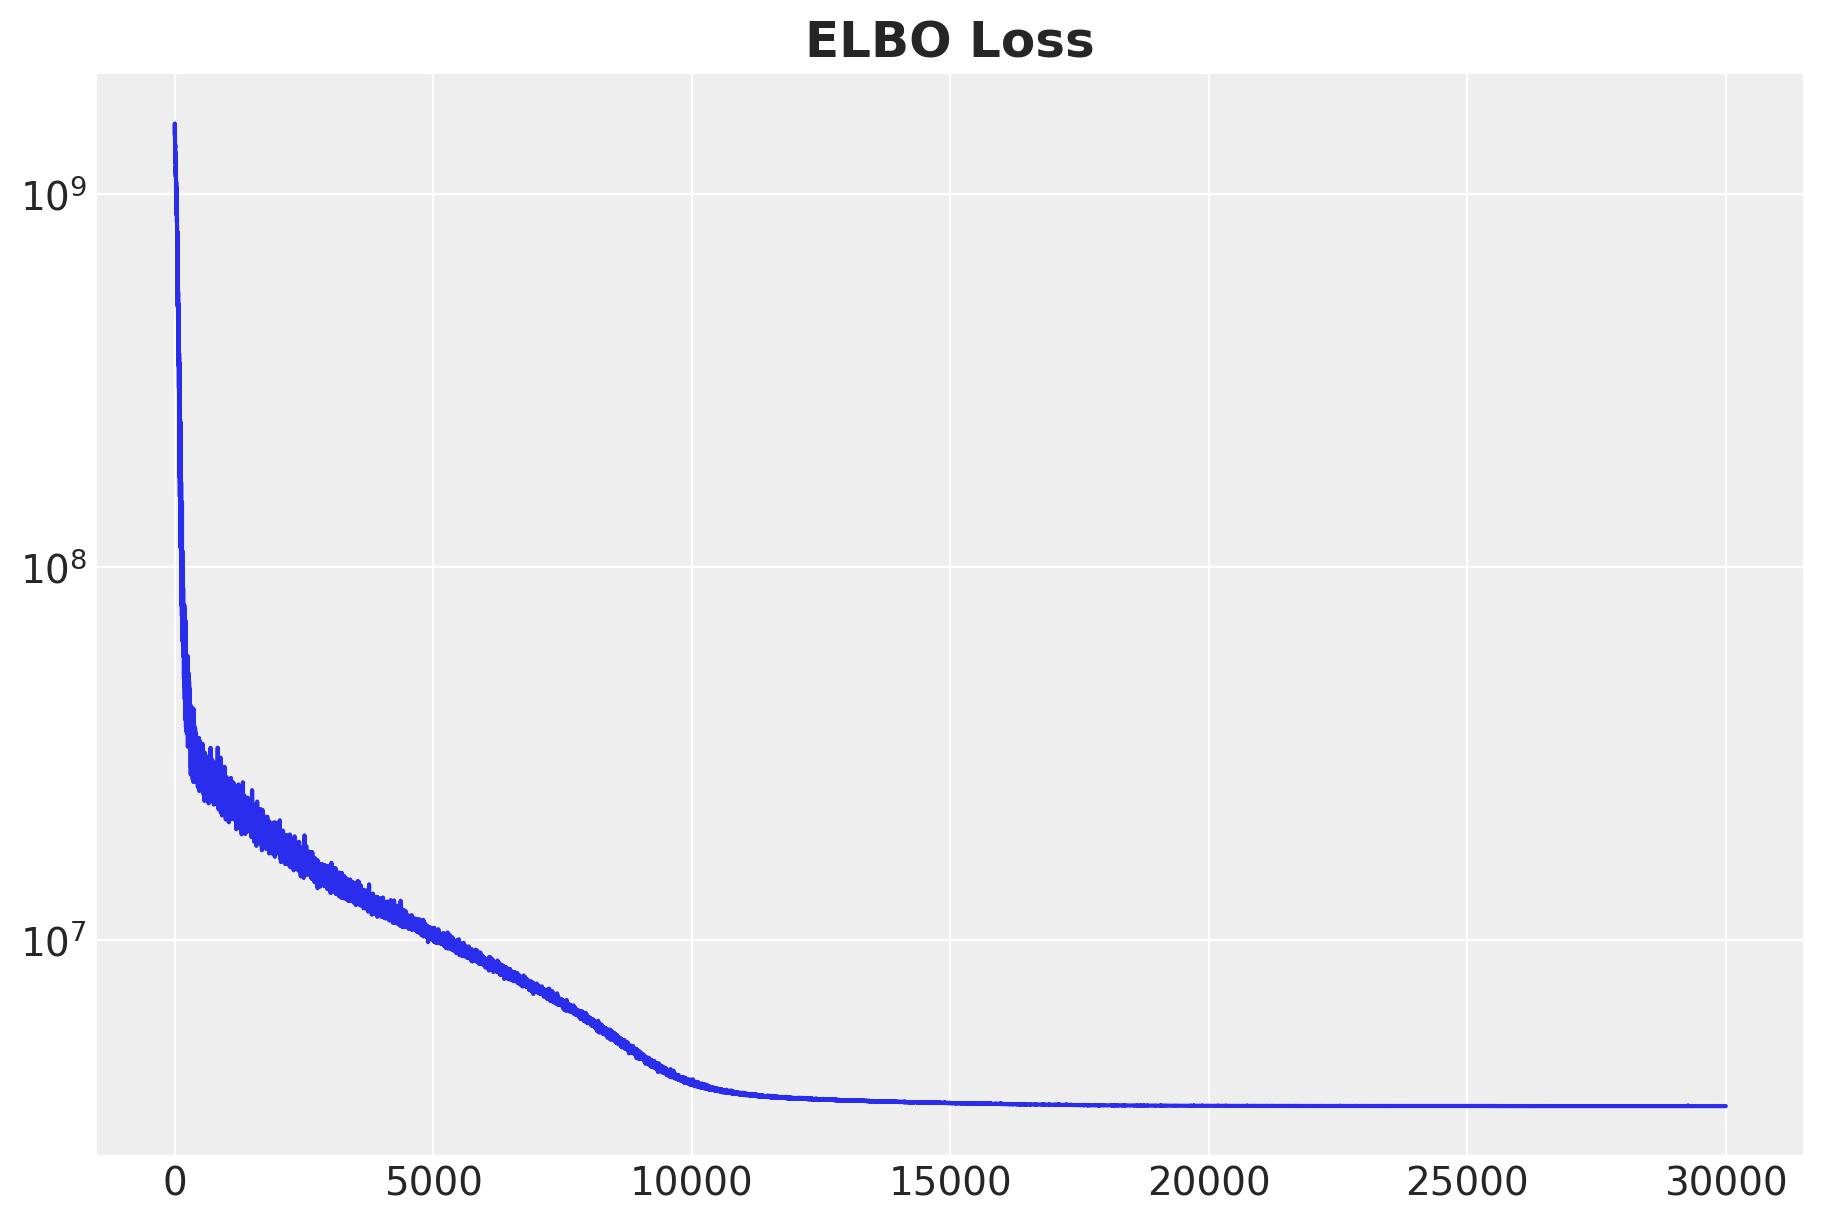

In [14]:
%%time

num_steps = 30_000

scheduler = optax.linear_onecycle_schedule(
    transition_steps=num_steps,
    peak_value=0.002,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=3,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.8,
        patience=20,
        accumulation_size=100,
    ),
)

guide = AutoNormal(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    transition_nn,
    y_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

The ELBO loss looks good.

## Posterior Predictive Checks

Now that we have learned the parameters, we can generate posterior predictive samples.


In [15]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=200,
    return_sites=["obs"],
)

rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...]
        for k, v in posterior(
            rng_subkey,
            covariates_train,
            transition_nn,
        ).items()
    },
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)


rng_key, rng_subkey = random.split(rng_key)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...]
        for k, v in posterior(
            rng_subkey,
            covariates,
            transition_nn,
        ).items()
    },
    coords={
        "time": time,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time"]},
)

We compute CRPS (same metric as Part II) to evaluate model performance.


In [16]:
@jax.jit
def crps(
    truth: Float[Array, "n_series n_series t_max"],
    pred: Float[Array, "n_samples n_series n_series t_max"],
    sample_weight: Float[Array, " t_max"] | None = None,
) -> Float[Array, ""]:
    if pred.shape[1:] != (1,) * (pred.ndim - truth.ndim - 1) + truth.shape:
        raise ValueError(
            f"""Expected pred to have one extra sample dim on left.
            Actual shapes: {pred.shape} versus {truth.shape}"""
        )

    absolute_error = jnp.mean(jnp.abs(pred - truth), axis=0)

    num_samples = pred.shape[0]
    if num_samples == 1:
        return jnp.average(absolute_error, weights=sample_weight)

    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))

    per_obs_crps = absolute_error - jnp.sum(diff * weight, axis=0) / num_samples**2
    return jnp.average(per_obs_crps, weights=sample_weight)


crps_train = crps(
    y_train,
    jnp.array(idata_train["posterior_predictive"]["obs"].sel(chain=0).clip(min=0)),
)

crps_test = crps(
    y_test,
    jnp.array(
        idata_test["posterior_predictive"]["obs"]
        .sel(chain=0)
        .sel(time=slice(T1, T2))
        .clip(min=0)
    ),
)

print(f"Train CRPS: {crps_train:.4f}")
print(f"Test CRPS: {crps_test:.4f}")

Train CRPS: 0.2297
Test CRPS: 0.2730


Finally, we visualize the model fit and forecast.


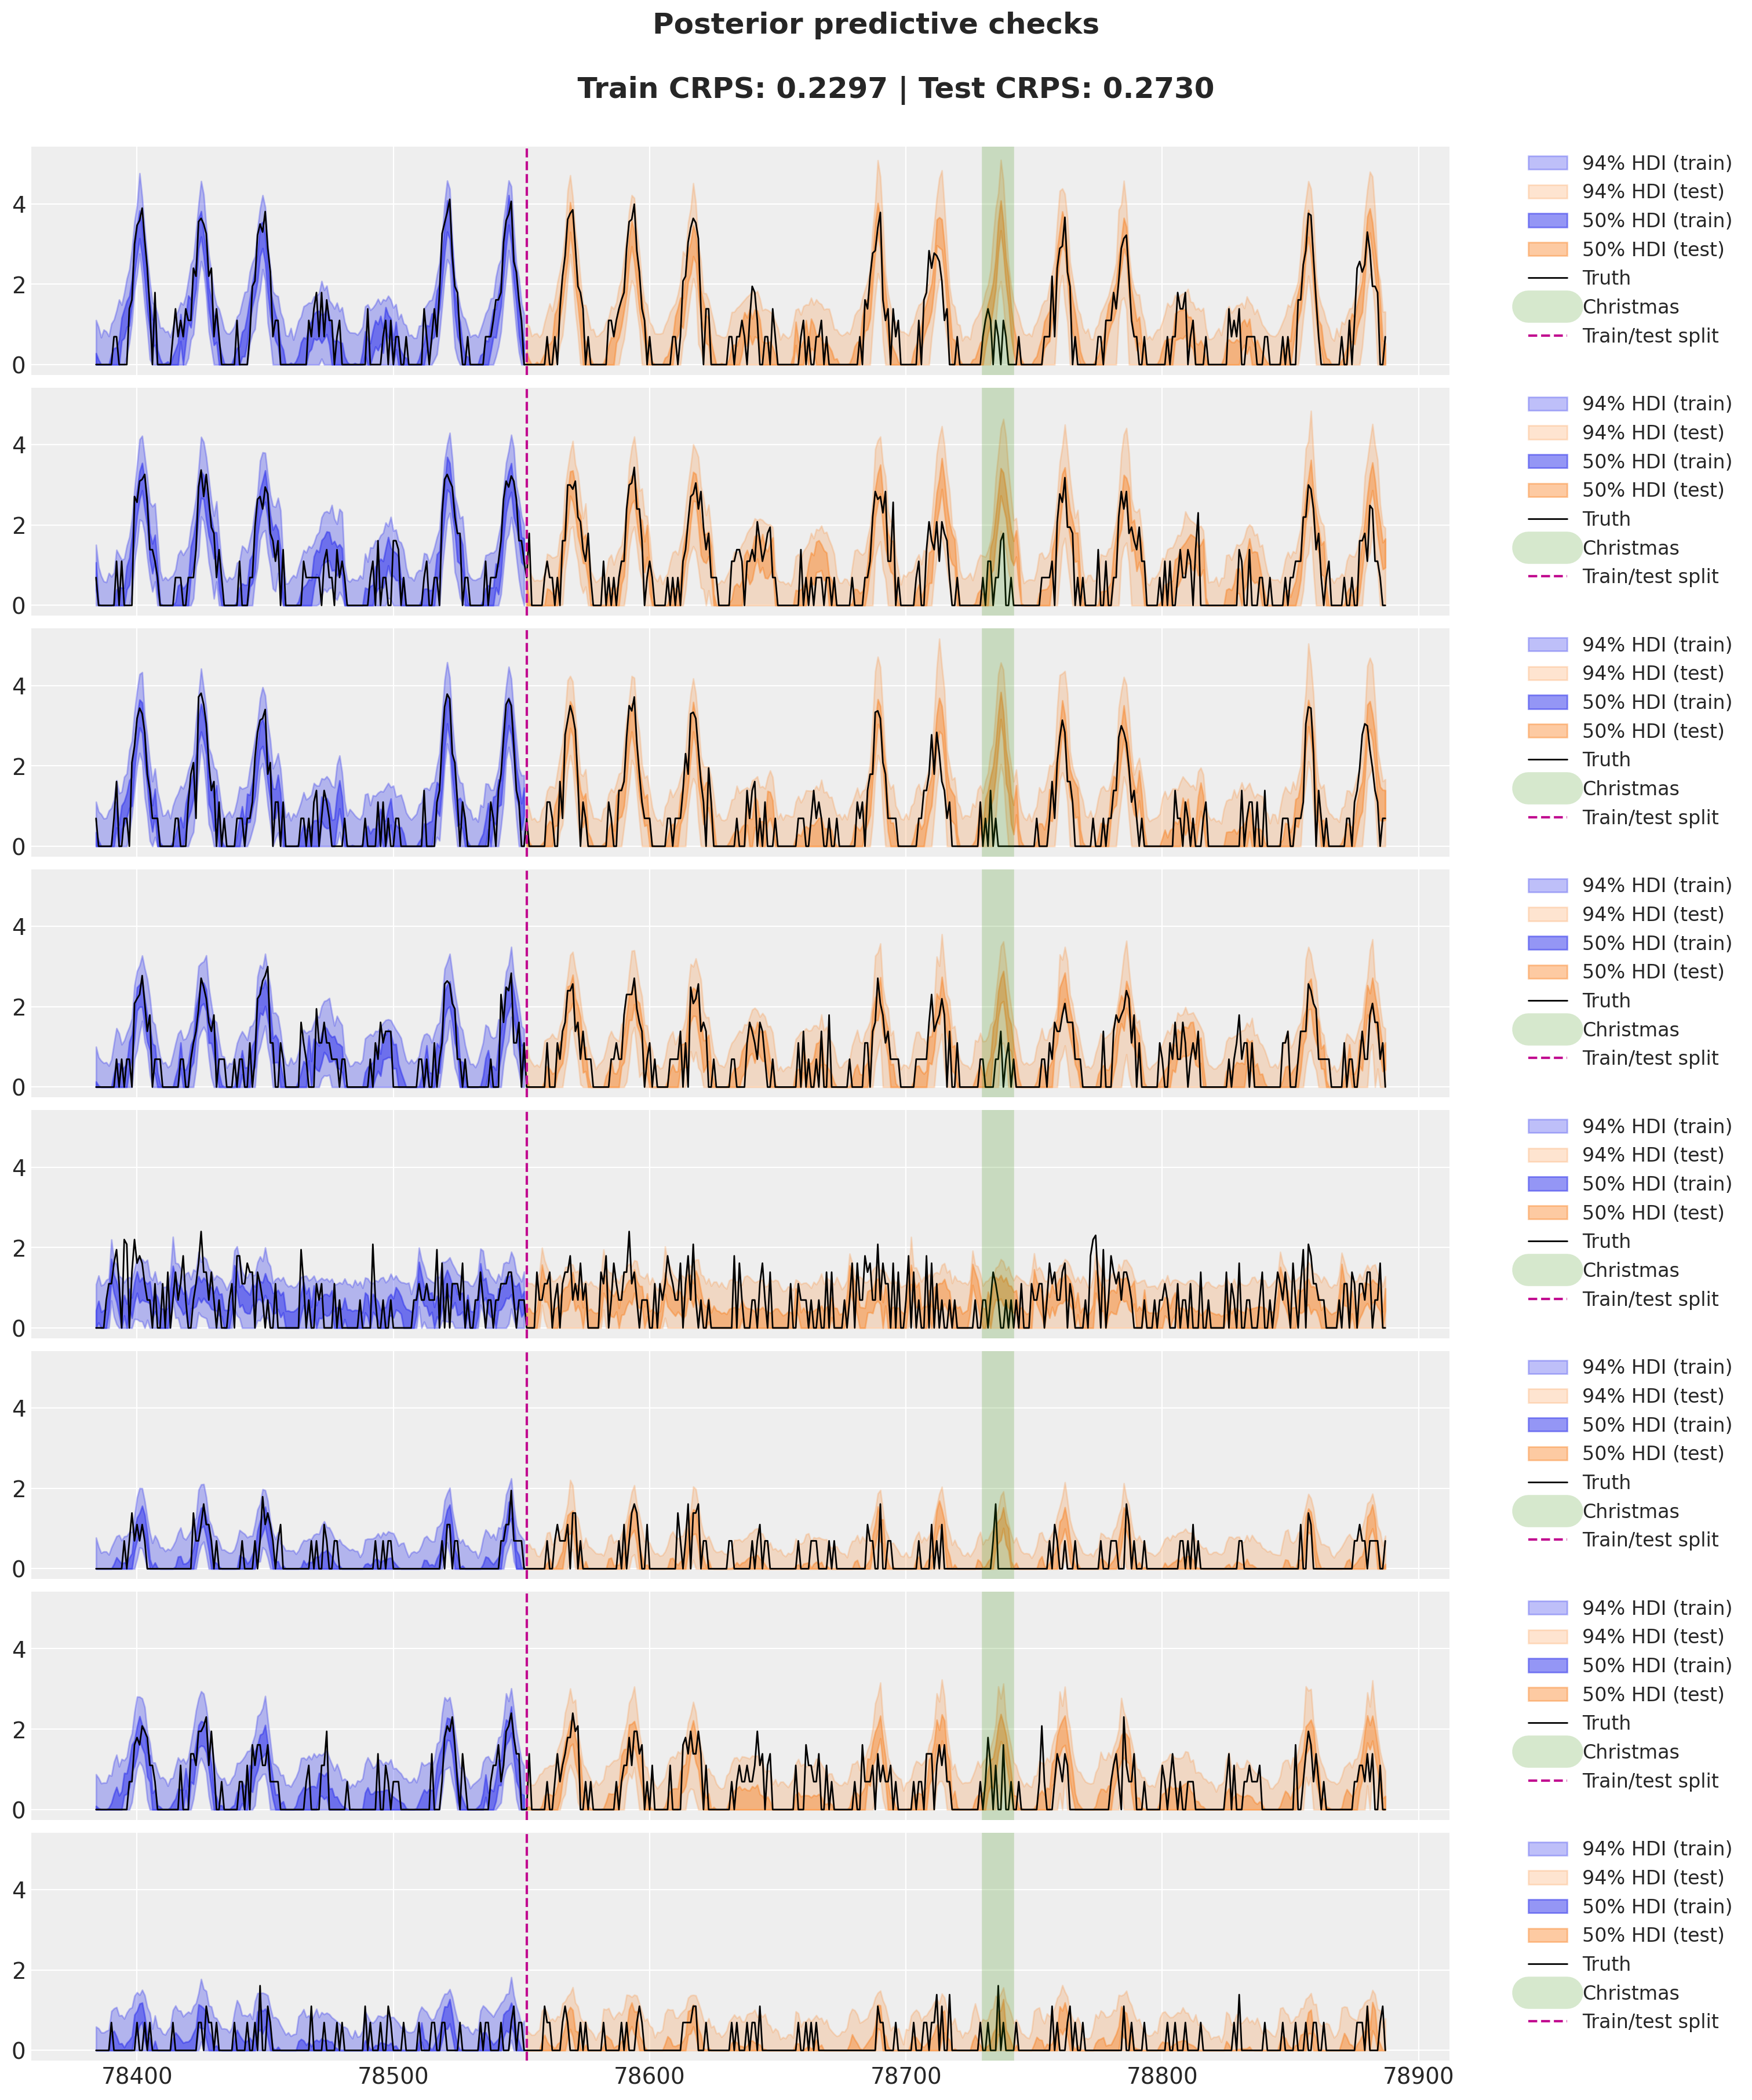

In [17]:
christmas_index = 78736

station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 24 * 7]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )

        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time) >= T1]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (test)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time[time >= T1 - 24 * 7],
        data[i, idx, T1 - 24 * 7 : T2],
        "black",
        lw=1,
        label="Truth",
    )

    ax.axvline(christmas_index, color="C2", lw=20, alpha=0.2, label="Christmas")

    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle(
    f"""Posterior predictive checks

    Train CRPS: {crps_train:.4f} | Test CRPS: {crps_test:.4f}
    """,
    fontsize=18,
    fontweight="bold",
);

In this specific example, the neural network correction term is not that important. Why could this be?

- The BART dataset is very seasonal, so the seasonal patterns are explaining most of the variation.
- The drift term is already very flexible to capture additional patterns.
- We are using a simple MLP (+ and embedding). We are not using the auto-regressive structure.

The minor improvement in the test CRPS is not worth the added complexity and could even be that the its a result of a better optimization component. Nevertheless, this is a good starting point for future experiments.